# Flood Inundation Mapping
STEPS INVOLVED:
1. Convert the contour data to continuous surface raster (DEM).
2. Map the natural drains

### Explore the contour data

In [3]:
import os
# set the basepath - folder containing data and where the ouput will be written
basepath = os.path.join(os.getcwd(), "Data")

In [17]:
from osgeo import ogr


# Open the geopackage
shp = ogr.Open("https://iudx-cat-sandbox-dev.s3.ap-south-1.amazonaws.com/flood-inundation-data/Contour_Lines%2C_Sirmaur%2C_Himachal_Pradesh_8192024.gpkg")
layer = shp.GetLayer()

# Print attribute names
layer_definition = layer.GetLayerDefn()
print("Attribute names:")
for i in range(layer_definition.GetFieldCount()):
    field_name = layer_definition.GetFieldDefn(i).GetName()
    print(f"- {field_name}")

# Print attributes of the first few features
print("\nAttributes of the first few features:")
for i, feature in enumerate(layer):
    if i >= 5:  # Limit to the first 5 features
        break
    print(f"\nFeature {i + 1}:")
    for j in range(layer_definition.GetFieldCount()):
        field_name = layer_definition.GetFieldDefn(j).GetName()
        field_value = feature.GetField(field_name)
        print(f"  {field_name}: {field_value}")

# Clean up
layer = None
shp = None


Attribute names:
- CATEGORY
- SUBCAT
- TYPE
- C_VALUE
- ADL_INFO

Attributes of the first few features:

Feature 1:
  CATEGORY: 2
  SUBCAT: 1
  TYPE: 1
  C_VALUE: 600.0
  ADL_INFO: HYP_Index_Brown_Contour_Reliable_L_

Feature 2:
  CATEGORY: 2
  SUBCAT: 1
  TYPE: 1
  C_VALUE: 600.0
  ADL_INFO: HYP_Index_Brown_Contour_Reliable_L_

Feature 3:
  CATEGORY: 2
  SUBCAT: 1
  TYPE: 1
  C_VALUE: 800.0
  ADL_INFO: HYP_Index_Brown_Contour_Reliable_L_

Feature 4:
  CATEGORY: 2
  SUBCAT: 1
  TYPE: 1
  C_VALUE: 1200.0
  ADL_INFO: HYP_Index_Brown_Contour_Reliable_L_

Feature 5:
  CATEGORY: 2
  SUBCAT: 1
  TYPE: 1
  C_VALUE: 1200.0
  ADL_INFO: HYP_Index_Brown_Contour_Reliable_L_


### STEP 1: Prepare continous surface raster from contour line

In [ ]:
# # set the basepath - folder containing data and where the ouput will be written
# basepath = os.path.join(os.getcwd(), "Data")

In [6]:
from osgeo import gdal, ogr, osr
import numpy as np
from scipy.interpolate import griddata

# Set your input and output paths
input_gpkg = os.path.join(basepath, "Contour_Lines,_Sirmaur,_Himachal_Pradesh_8192024.gpkg")
output_tif = os.path.join(basepath, "contour_raster.tif")

# Open the geopackage
shp = ogr.Open(input_gpkg)
layer = shp.GetLayer()

# Get extent
x_min, x_max, y_min, y_max = layer.GetExtent()

# Create a blank raster
pixel_size = 30  # Adjust this to your desired resolution
x_res = int((x_max - x_min) / pixel_size)
y_res = int((y_max - y_min) / pixel_size)

target_ds = gdal.GetDriverByName('GTiff').Create(output_tif, x_res, y_res, 1, gdal.GDT_Float32)
target_ds.SetGeoTransform((x_min, pixel_size, 0, y_max, 0, -pixel_size))

# Set CRS (Coordinate Reference System)
spatial_ref = layer.GetSpatialRef()
target_ds.SetProjection(spatial_ref.ExportToWkt())

# Rasterize the contour lines with C_VALUE as the burn value
gdal.RasterizeLayer(target_ds, [1], layer, options=["ATTRIBUTE=C_VALUE"]) #the attribute C-VALUE has the elevation information

# Load the rasterized layer into a numpy array
band = target_ds.GetRasterBand(1)
raster_data = band.ReadAsArray()

# Check if raster_data contains any valid values
if np.isnan(raster_data).all():
    raise ValueError("Raster data contains no valid values. Check the contour attribute and input data.")

# Interpolate to create a continuous surface
# Replace zeros with NaN
raster_data = np.where(raster_data == 0, np.nan, raster_data)

# Prepare the interpolation points
x = np.arange(0, raster_data.shape[1])
y = np.arange(0, raster_data.shape[0])
x, y = np.meshgrid(x, y)

# Mask the valid points
points = np.column_stack((x[~np.isnan(raster_data)], y[~np.isnan(raster_data)]))
values = raster_data[~np.isnan(raster_data)]

# Ensure there are valid points for interpolation
if points.size == 0 or values.size == 0:
    raise ValueError("No valid points found for interpolation. Check the rasterization step.")

# Interpolate the surface
'''
-----------------------------------------------------------------------------------
For this exercise cubic interpolation is used.
You can also try  nearest and linear.
source: https://docs.scipy.org/doc/scipy/tutorial/interpolate/ND_unstructured.html
------------------------------------------------------------------------------------
'''
raster_data_interp = griddata(points, values, (x, y), method='cubic')

# Replace NaNs with original values
raster_data_interp[np.isnan(raster_data_interp)] = raster_data[np.isnan(raster_data_interp)]

# Write interpolated data back to the raster
band.WriteArray(raster_data_interp)
band.FlushCache()

# Close the datasets
band = None
target_ds = None

print("Rasterization and interpolation completed successfully!")


ERROR 1: PROJ: proj_create_from_database: Open of /home/rraks/.conda/envs/sci/share/proj failed


Rasterization and interpolation completed successfully!


In [8]:
# Read elevation raster

from pysheds.grid import Grid

grid = Grid.from_raster(output_tif) # output_tif has the path to the DEM generated.
dem = grid.read_raster(output_tif)

/home/rraks/.conda/envs/sci/lib/python3.12/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/home/rraks/.conda/envs/sci/lib/python3.12/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


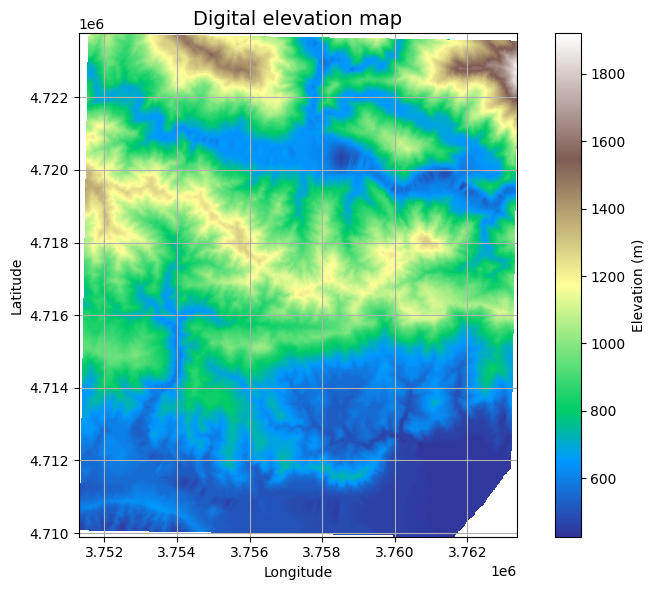

In [11]:
# visualize DEM raster generated
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
# In cmap, you define color palatte of your choice 
#(https://matplotlib.org/stable/users/explain/colors/colormaps.html)
plt.imshow(dem, extent=grid.extent, cmap='terrain', zorder=1) 
plt.colorbar(label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Digital elevation map', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

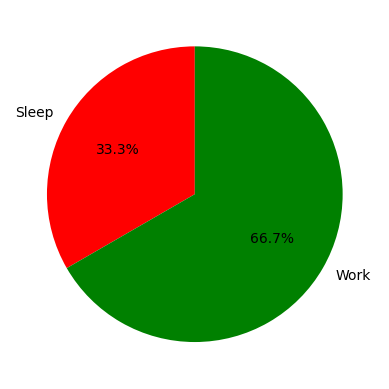

In [12]:
import matplotlib.pyplot as plt
slices_hours = [4, 8]
activities = ['Sleep', 'Work']
colors = ['r', 'g']
plt.pie(slices_hours, labels=activities, colors=colors, startangle=90, autopct='%.1f%%')
plt.show()

## FLOOD INUNDATION USING FLOOD FILL ALGORITHM

source code for flood fill algorithm: https://github.com/royalosyin/Work-with-DEM-data-using-Python-from-Simple-to-Complicated/blob/master/ex01-Exploratory%20Flood%20Inundation%20Model%20with%20Flood%20Fill%20Algorithm.ipynb

### a. Flood inundation with one threshold value
(The minimum elevation value in the data is 426.63848876953125 m. So ensure the threshold value specified is larger than minimum elevation.)

___________________________________________________________________________________________________________________________________________
***Flood inundation map is prepared using flood fill algorithm. Assume the areas with elevation < 900m will get inundated. First a binary mask is prepared with DEM as input and conditioned - (DEM < 900, 1, 0). Those cell with DEM values less that 900 will be 1.***

***Then identify the location (sy, sx) the cell with minimum elevation value. This will act as seed cell where the algorithm starts.***

***Then binary mask prepared and the seed cell location (sy, sx) will be input into flood fill algorithm***

***The algorithm starts by checking the 4 neighbours to the seed cell, if the value is 1. The order of check is left (x-1, y), right (x+1, y), down(x, y-1), up(x, y+1) and again fill with values 1 and 0 - denoting inundated or not. All the cells with the the mask is checked progressively. Also inorder to avoid checking previously checked cell - set function is introduced.***
___________________________________________________________________________________________________________________________________________

Minimum Elevation: 426.63848876953125 m
Maximum Elevation: 1920.0 m
Starting flood fill...
Flood fill completed.


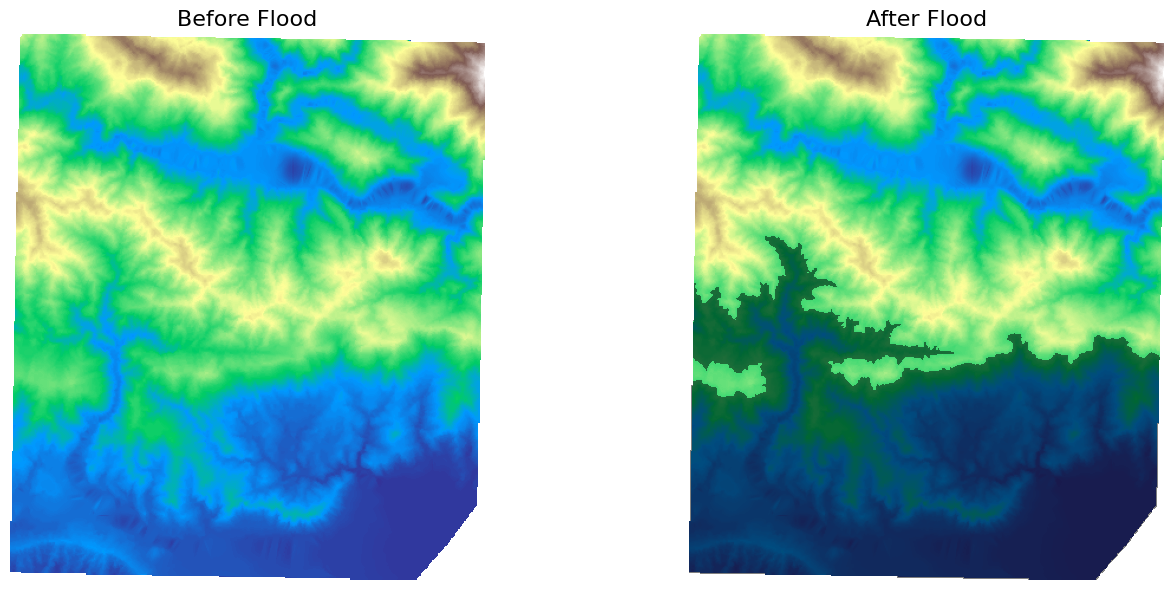

<Figure size 640x480 with 0 Axes>

In [14]:
import os
import numpy as np
import rioxarray  # Use rioxarray instead of xarray for raster data
import matplotlib.pyplot as plt
import warnings
from matplotlib.colors import ListedColormap

# warnings.filterwarnings("ignore")

# Define flood fill method
def floodFill(c, r, mask):
    """
    Perform a 4-way flood fill on a mask array starting from (c, r).
    
    Args:
    c (int): Column index (x-coordinate).
    r (int): Row index (y-coordinate).
    mask (np.ndarray): Binary mask array indicating areas to be filled (1) or not (0).
    
    Returns:
    np.ndarray: Flood-filled array with flooded areas marked as 1.
    """
    filled = set()  # To track processed cells
    fill = set([(c, r)])  # To track cells to be filled
    height, width = mask.shape
    flood = np.zeros_like(mask, dtype=np.int8)  # Output array for inundated areas

    while fill:
        x, y = fill.pop()
        if x < 0 or x >= width or y < 0 or y >= height:
            continue
        if mask[y, x] == 1:
            flood[y, x] = 1
            filled.add((x, y))
            # Check and add neighboring cells
            neighbors = [(x-1, y), (x+1, y), (x, y-1), (x, y+1)]
            for neighbor in neighbors:
                if neighbor not in filled:
                    fill.add(neighbor)

    return flood

# Read DEM data
# output_tif - has the path to the DEM generated

# Use rioxarray to open the raster file
da_dem = rioxarray.open_rasterio(output_tif).isel(band=0)
da_dem = da_dem.where(da_dem >= 0, np.nan)  # Masking invalid DEM values

# Display DEM statistics
print(f"Minimum Elevation: {da_dem.min().item()} m")
print(f"Maximum Elevation: {da_dem.max().item()} m")

# Start Floodfill from the lowest point in the DEMhttp://127.0.0.1:8888/tree?token=b981dd43a17b717636137c9d8886d4c1c3d793024867d0d8

sy, sx = np.unravel_index(da_dem.argmin(), da_dem.shape)

# Define a threshold elevation for flood inundation (e.g., 900m)
threshold = 900
img = da_dem.values
mask = np.where(img < threshold, 1, 0)  # Binary mask: 1 for areas below threshold

# Begin the flood fill algorithm
print("Starting flood fill...")
flooded = floodFill(sx, sy, mask)
print("Flood fill completed.")

# Visualization
fig, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Original DEM with terrain color palette
dem_plot = ax[0].imshow(da_dem, cmap='terrain')
ax[0].set_title('Before Flood', fontsize=16)
ax[0].axis('off')

# DEM with flood overlay
ax[1].imshow(da_dem, cmap='terrain')
flood_cmap = ListedColormap(['none', 'black'])  # Binary flood map: 1 -> blue, 0 -> no color
ax[1].imshow(flooded, cmap=flood_cmap, alpha=0.5)  # Overlay flood on DEM
ax[1].set_title('After Flood', fontsize=16)
ax[1].axis('off')

# Adjust layout and show plots
plt.tight_layout()
plt.show()
plt.savefig(os.path.join(basepath, 'Flood inundation.png'))

### b. Flood inundation for a list of threshold value
(Animation is generated by running flood fill algorithm for different threshold value in each frame. Then animates using the frames and saves as html file. The same html opens in a new browser)

In [15]:
import os
import numpy as np
import rioxarray
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.animation import FuncAnimation
import warnings
from IPython.display import HTML
import webbrowser


warnings.filterwarnings("ignore")

# Define flood fill method
def floodFill(c, r, mask):
    filled = set()
    fill = set([(c, r)])
    height, width = mask.shape
    flood = np.zeros_like(mask, dtype=np.int8)

    while fill:
        x, y = fill.pop()
        if x < 0 or x >= width or y < 0 or y >= height:
            continue
        if mask[y, x] == 1:
            flood[y, x] = 1
            filled.add((x, y))
            neighbors = [(x-1, y), (x+1, y), (x, y-1), (x, y+1)]
            for neighbor in neighbors:
                if neighbor not in filled:
                    fill.add(neighbor)

    return flood

# Read DEM data
# output_tif - has the path to the DEM generated
da_dem = rioxarray.open_rasterio(output_tif).isel(band=0)
da_dem = da_dem.where(da_dem >= 0, np.nan)  # Masking invalid DEM values

# Define threshold values
thresholds = [500, 550, 600, 650, 700, 750, 800, 850, 900]  # Replace with the threshold values of your choice
img = da_dem.values

# Setup animation plot
fig, ax = plt.subplots()
flood_cmap = ListedColormap(['none', 'blue'])  # Only flooded areas will show up in blue

# Function to update each frame in the animation
def update(threshold):
    ax.clear()  # Clear previous frame
    mask = np.where(img < threshold, 1, 0)
    flooded = floodFill(sx, sy, mask)
    # Display DEM
    ax.imshow(da_dem, cmap='terrain', vmin=np.nanmin(img), vmax=np.nanmax(img))
    # Overlay flood mask
    ax.imshow(flooded, cmap=flood_cmap, alpha=0.5)
    ax.set_title(f'After Flood (Threshold: {threshold}m)', fontsize=16)
    ax.axis('off')

# Find the lowest point in the DEM to start flood fill
sy, sx = np.unravel_index(da_dem.argmin(), da_dem.shape)

# Create animation
ani = FuncAnimation(fig, update, frames=thresholds, repeat=True) 

# Save the animation as an HTML file
html_path = os.path.join(basepath, 'flood_animation.html')
ani.save(html_path, writer='html')

# Display the HTML file in the browser
webbrowser.open(html_path)

plt.close(fig)  # Close the plot to prevent it from displaying in this environment
